### **Description Project**
We used the "Diabetes Clinical Dataset (100k rows)", which contains detailed health and demographic information for 100,000 individuals. The dataset includes features such as gender, age, location, race, hypertension, heart disease, smoking history, BMI, HbA1c level, blood glucose level, and the target variable (diabetes). This dataset is well-suited for predictive modeling, health analytics, and clinical research on diabetes.

### Models Evaluated:
- Four classification models were developed:
    - AdaBoost 
    - XGB (XGBoost)
    - Random Forest (RF)
    - LGBM Classifier (LightGBM)
- These models were assessed under two diff
    1. Without Imbalance Techniques 
    2. With Imbalance Techniques using three methods:
        - ADASYN
        - SMOTE
        - Random Undersampler
---
### Results Without Imbalance Techniques:
- Training/Testing Scores:
    - AdaBoost: ~0.9718 / 0.9723
    - XGB: ~0.9772 / 0.9713
    - Random Forest: ~1.0000 / 0.9724
    - LGBM: ~0.9390 / 0.9264
- Observations from Classification Reports:
    - Although overall accuracy is high (~97%) for AdaBoost, XGB, and RF, the models struggle with correctly classifying the minority class (diabetes-positive).
    - For instance, the recall for the diabetes class in AdaBoost is only 0.67, and similar trends are seen in XGB and RF.
    - LGBM shows particularly low precision (0.54) for the minority class, even though its recall is relatively high (0.88).
- **Interpretation:** While the models achieve excellent overall accuracy, they fail to adequately capture the minority class, which is critical in a medical diagnosis scenario.
---
### Results With Imbalance Techniques:
1. **ADASYN**
    - XGB, RF, and LGBM maintained high testing scores (~0.968–0.971) with improved class balance and macro f1-scores approaching 0.89.
    - AdaBoost experienced an increase in recall for the minority class (up to 0.88) but at the cost of a significant drop in precision (around 0.44), resulting in an overall lower f1-score and testing score (~0.893).
2. **SMOTE**
    - The application of SMOTE yielded similar improvements as ADASYN for XGB, RF, and LGBM, with testing scores near 0.97 and balanced classification metrics.
    - Again, AdaBoost’s performance, while slightly improved, did not match the consistency of the other models.
3. **Random Undersampler**
    - This method led to a significant drop in performance across all models, with testing scores around 0.90 and macro f1-scores in the range of 0.77–0.78.
    - The reduction in the training data size appears to have removed important information, thereby degrading model performance.
- **Interpretation:** Oversampling techniques (ADASYN and SMOTE) help to improve the detection of the minority class without compromising the overall accuracy—especially for XGB, RF, and LGBM. In contrast, random undersampling is less effective, as it significantly reduces the available data for training and, consequently, the model’s performance.

# **Import Library**

In [ ]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas.api.types
import math
import lightgbm
import torch
import torch.nn as nn
import torch.optim as optim


from torch.utils.data import Dataset, DataLoader, TensorDataset
from lightgbm import LGBMClassifier, LGBMRegressor
from scipy.stats import zscore, randint, uniform, loguniform
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, AdaBoostRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, davies_bouldin_score, brier_score_loss, mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier, XGBRegressor
from lifelines.utils import concordance_index
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score

# **Load Dataset**

In [2]:
df = pd.read_csv("data/diabetes_dataset_with_notes.csv")
df.head()

,year,gender,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes,clinical_notes
0,2020,Female,32.0,Alabama,0,0,0,0,1,0,0,never,27.32,5.0,100,0,"Overweight, advised dietary and exercise modif..."
1,2015,Female,29.0,Alabama,0,1,0,0,0,0,0,never,19.95,5.0,90,0,Healthy BMI range.
2,2015,Male,18.0,Alabama,0,0,0,0,1,0,0,never,23.76,4.8,160,0,"Young patient, generally lower risk but needs ..."
3,2015,Male,41.0,Alabama,0,0,1,0,0,0,0,never,27.32,4.0,159,0,"Overweight, advised dietary and exercise modif..."
4,2016,Female,52.0,Alabama,1,0,0,0,0,0,0,never,23.75,6.5,90,0,"Healthy BMI range. High HbA1c level, indicativ..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   year                  100000 non-null  int64  
 1   gender                100000 non-null  object 
 2   age                   100000 non-null  float64
 3   location              100000 non-null  object 
 4   race:AfricanAmerican  100000 non-null  int64  
 5   race:Asian            100000 non-null  int64  
 6   race:Caucasian        100000 non-null  int64  
 7   race:Hispanic         100000 non-null  int64  
 8   race:Other            100000 non-null  int64  
 9   hypertension          100000 non-null  int64  
 10  heart_disease         100000 non-null  int64  
 11  smoking_history       100000 non-null  object 
 12  bmi                   100000 non-null  float64
 13  hbA1c_level           100000 non-null  float64
 14  blood_glucose_level   100000 non-null  int64  
 15  d

In [4]:
print("Number of missing values : ")
print(df.isnull().sum())
print(f"Total Data : {df.shape[0]}")

Number of missing values : 
year                    0
gender                  0
age                     0
location                0
race:AfricanAmerican    0
race:Asian              0
race:Caucasian          0
race:Hispanic           0
race:Other              0
hypertension            0
heart_disease           0
smoking_history         0
bmi                     0
hbA1c_level             0
blood_glucose_level     0
diabetes                0
clinical_notes          0
dtype: int64
Total Data : 100000


# **Exploratory Data Analysis**

In [5]:
num_col = df.select_dtypes(include=[np.number])   
cat_col = df.select_dtypes(include=[object])

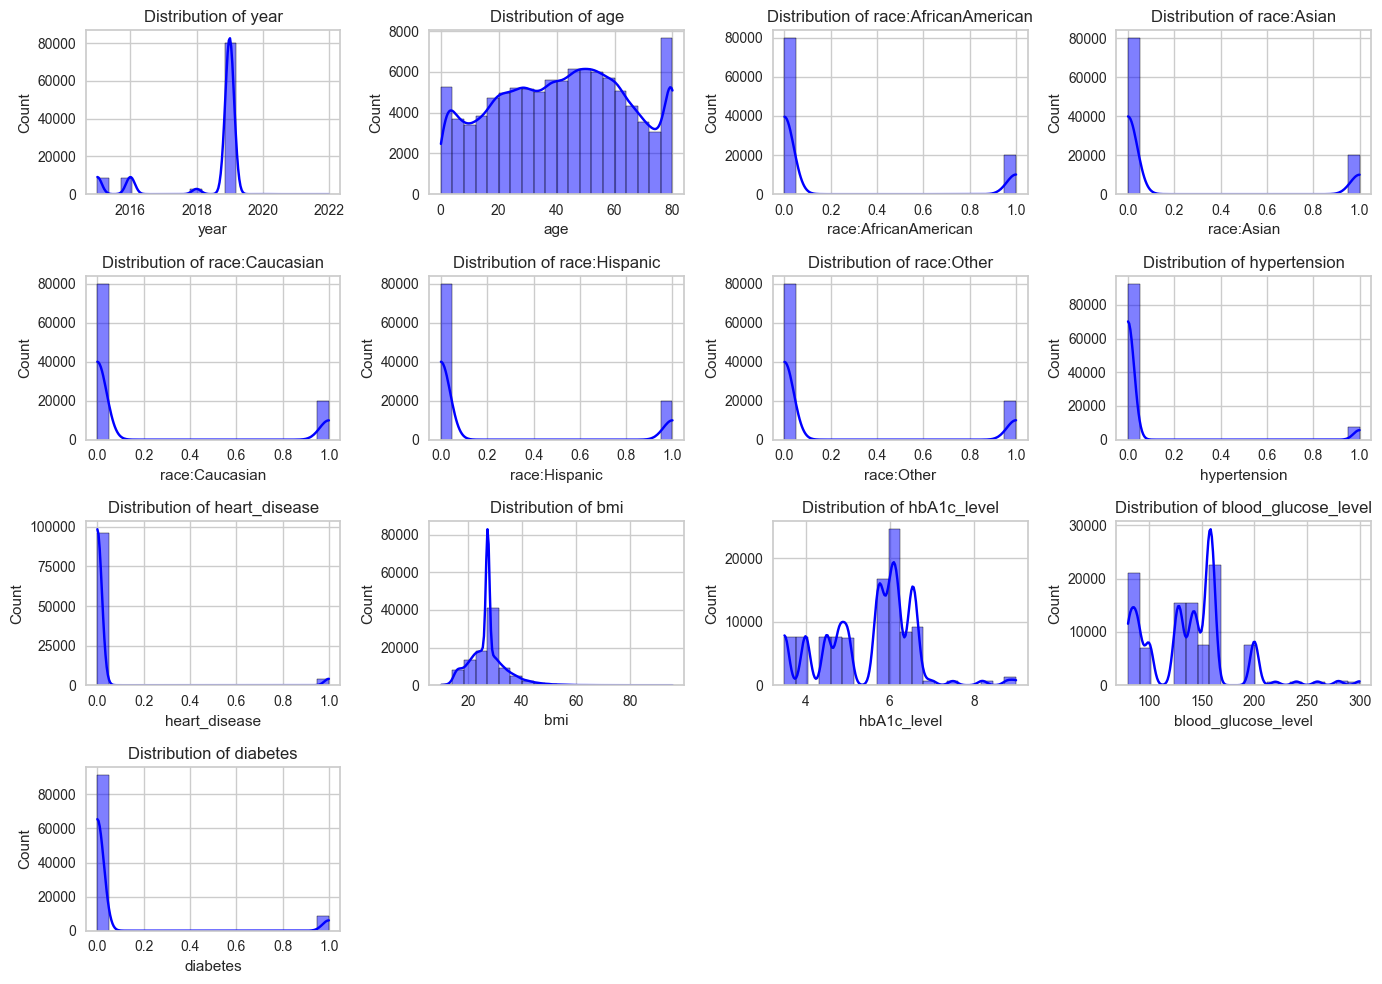

In [6]:
# EDA for Categoric Columns
n_cols = len(num_col.columns)
n_rows = math.ceil(n_cols / 4)  
plt.figure(figsize=(14, 10))
for i, column in enumerate(num_col.columns, 1):
    plt.subplot(n_rows, 4, i)
    sns.histplot(df[column], bins=20, kde=True, color='blue')
    plt.title(f"Distribution of {column}")
plt.tight_layout()
plt.show()

Plotting:   0%|          | 0/4 [00:00<?, ?it/s]

Plotting: 100%|██████████| 4/4 [00:00<00:00,  5.63it/s]
C:\Users\windows\AppData\Local\Temp\ipykernel_21568\3053000863.py:20: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout(rect=[0, 0, 1, 0.96])


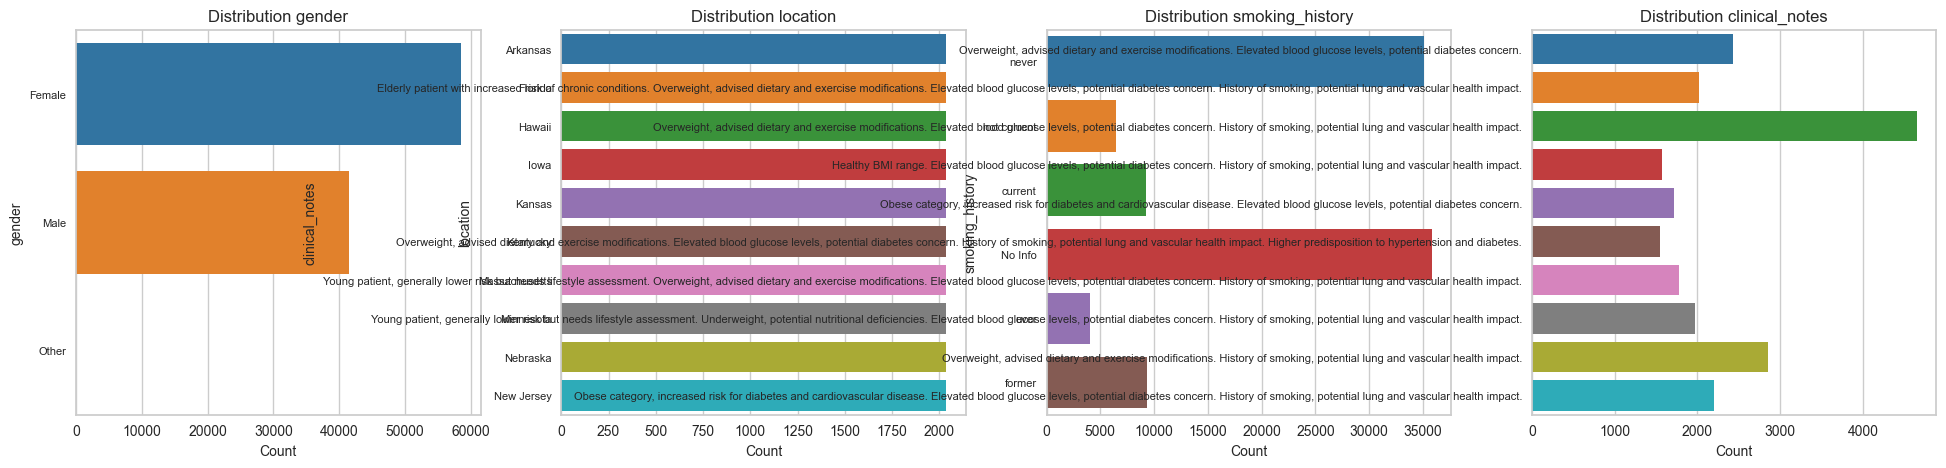

In [7]:
# EDA untuk Distribusi data kategorik
size_cat = len(cat_col.columns)
rows = math.ceil(size_cat / 4)
fig, axes = plt.subplots(rows, 4, figsize=(24, 5 * rows)) 
axes = axes.flatten()  

for i, column in tqdm(enumerate(cat_col.columns), total=size_cat, desc="Plotting"):
    top_categories = df[column].value_counts().nlargest(10).index
    filtered_df = df[df[column].isin(top_categories)]
    sns.countplot(y=filtered_df[column], hue=filtered_df[column], ax=axes[i],
                  palette='tab10', legend=False)
    axes[i].set_title(f'Distribution {column}', fontsize=12)
    axes[i].set_xlabel('Count', fontsize=10)
    axes[i].set_ylabel(column, fontsize=10)
    plt.setp(axes[i].get_yticklabels(), fontsize=8)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# **Data Preparation**

In [7]:
df.head(3)

,year,gender,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes,clinical_notes
0,2020,Female,32.0,Alabama,0,0,0,0,1,0,0,never,27.32,5.0,100,0,"Overweight, advised dietary and exercise modif..."
1,2015,Female,29.0,Alabama,0,1,0,0,0,0,0,never,19.95,5.0,90,0,Healthy BMI range.
2,2015,Male,18.0,Alabama,0,0,0,0,1,0,0,never,23.76,4.8,160,0,"Young patient, generally lower risk but needs ..."


### **Drop Unused Columns**

In [8]:
df.drop(columns=['year'], inplace=True)
df.head(3)

,gender,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes,clinical_notes
0,Female,32.0,Alabama,0,0,0,0,1,0,0,never,27.32,5.0,100,0,"Overweight, advised dietary and exercise modif..."
1,Female,29.0,Alabama,0,1,0,0,0,0,0,never,19.95,5.0,90,0,Healthy BMI range.
2,Male,18.0,Alabama,0,0,0,0,1,0,0,never,23.76,4.8,160,0,"Young patient, generally lower risk but needs ..."


## **Label Encoding**

In [9]:
encoder = LabelEncoder()

for column in cat_col.columns:
    df[column] = encoder.fit_transform(df[column])

# **Heatmap Correlation**

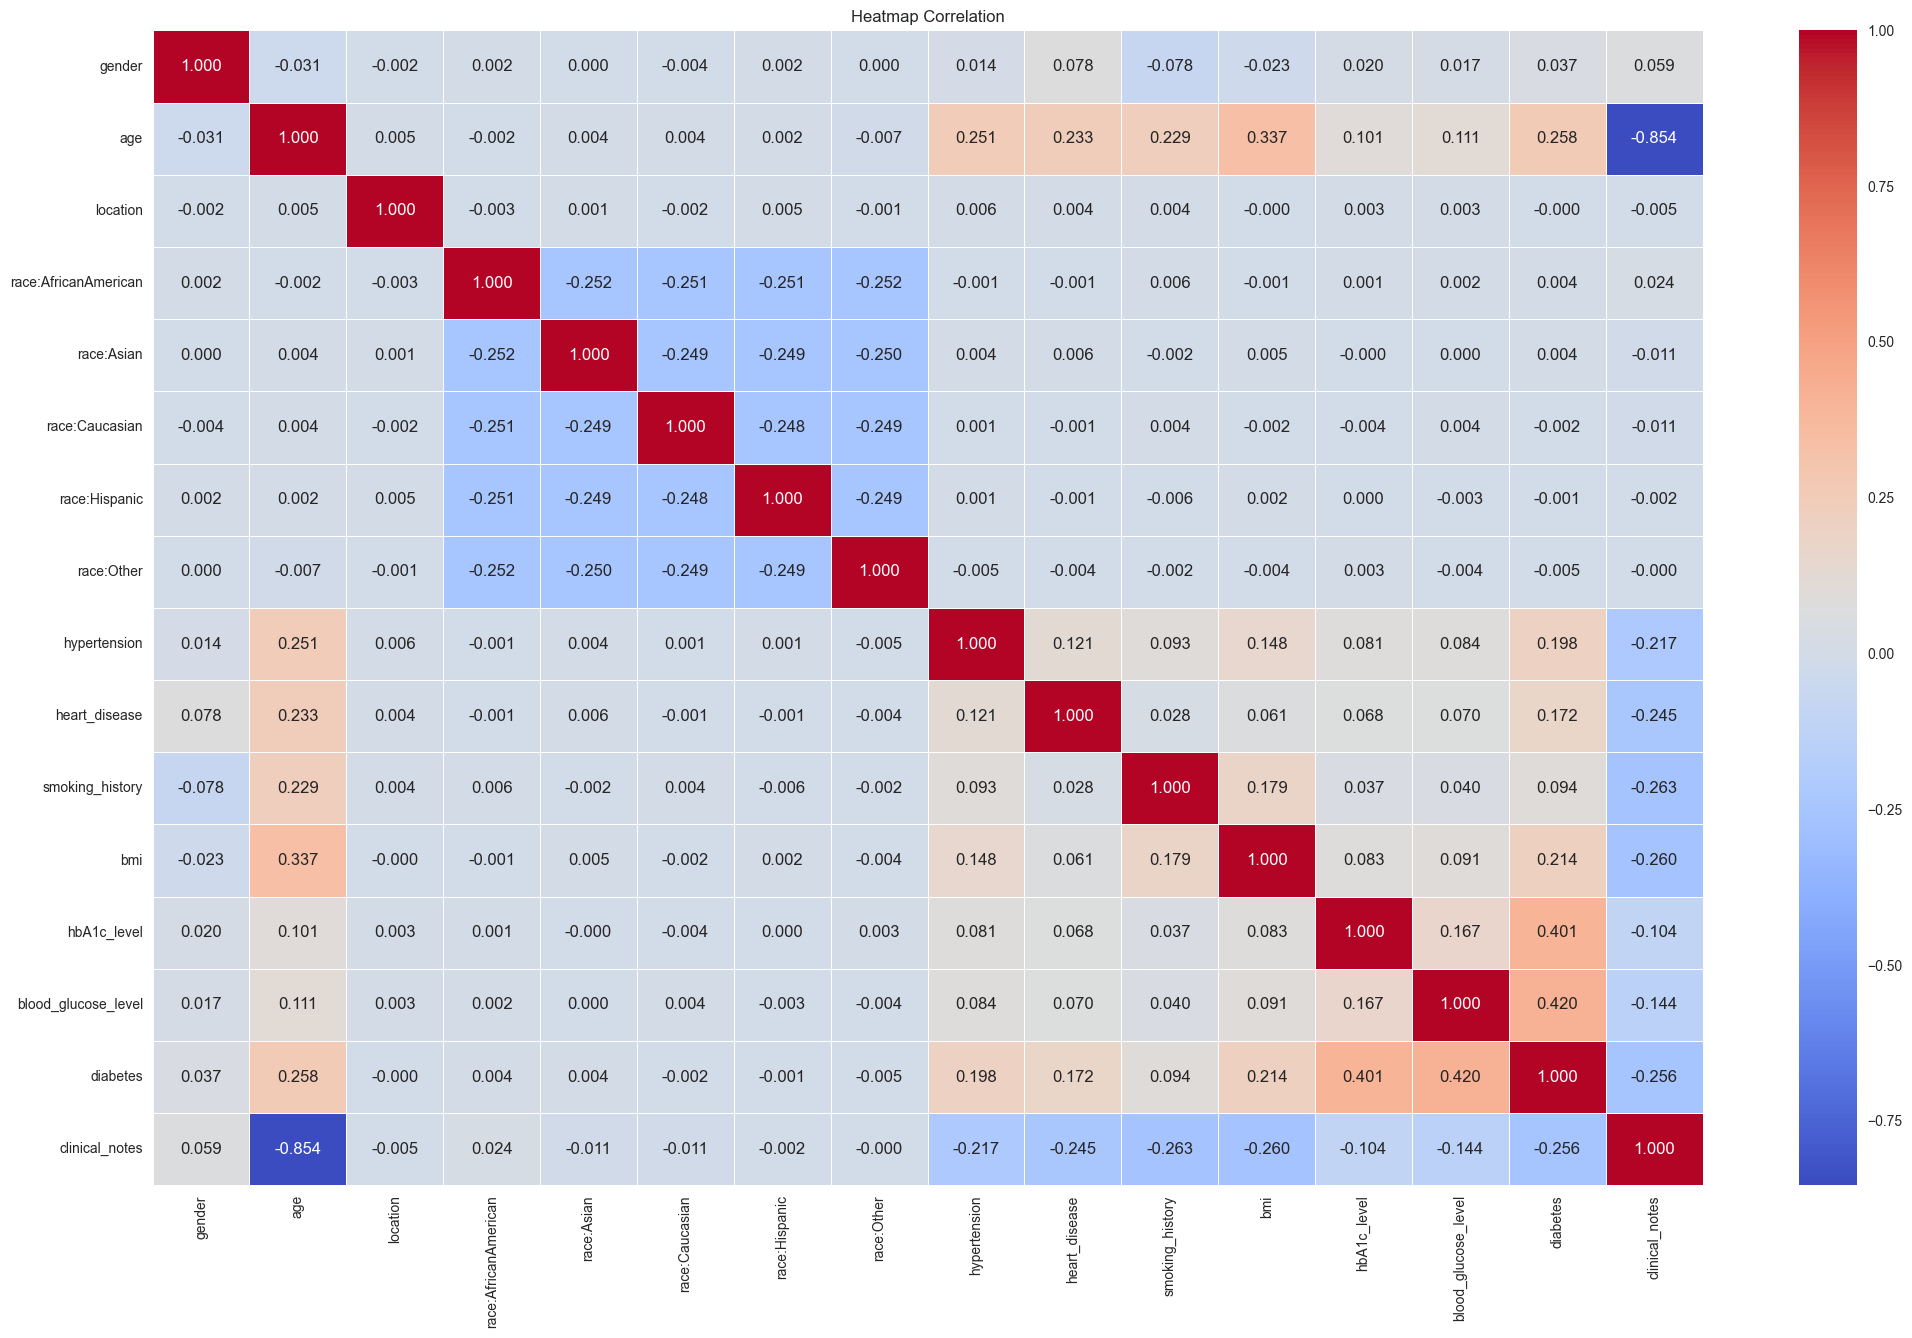

In [10]:
plt.figure(figsize=(25, 15))
correlation_matrix = df.corr()  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.3f', linewidths=0.5)
plt.title('Heatmap Correlation')
plt.show()

# **Check Imbalance Dataset**

### **Check for Imbalanced Dataset**

In [11]:
df['diabetes'].unique()

array([0, 1])

In [12]:
print(df['diabetes'].value_counts(normalize=True) * 100)

diabetes
0    91.5
1     8.5
Name: proportion, dtype: float64


#### **Since the target in the data has an imbalanced amount, we will apply several techniques to overcome this. Such as SMOTE, ADASYN or using Randomsampler**

# **Function for format UTF-8**

In [13]:
def clean_column(col: str) -> str:
    return re.sub(r'[^A-Za-z0-9_]', '_', col)

# **Data Modelling**

### **Without Imbalance Technique**

In [14]:
X = df.drop(columns=['diabetes'], axis=1)
y = df['diabetes']
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((80000, 15), (20000, 15), (80000,), (20000,))

In [15]:
X_train.columns = [clean_column(col) for col in X_train.columns]
X_val.columns = [clean_column(col) for col in X_val.columns]

In [16]:
model_ada      = AdaBoostClassifier(algorithm='SAMME')
model_rf       = RandomForestClassifier()
model_xgb      = XGBClassifier()
model_lgbm_clf = LGBMClassifier(
    objective='binary',        
    boosting_type='gbdt',
    num_leaves=41,
    learning_rate=0.023,
    colsample_bytree=1.0,
    n_estimators=600,
    metric=['auc', 'f1', 'accuracy'],
    class_weight='balanced',        
    random_state=42
)

In [17]:
model_ada.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
model_xgb.fit(X_train, y_train)
model_lgbm_clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],  
    eval_metric=['auc', 'f1', 'accuracy'],  
    callbacks=[lightgbm.log_evaluation(30)]  
)

[LightGBM] [Info] Number of positive: 6800, number of negative: 73200
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 708
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[30]	valid_0's auc: 0.976094
[60]	valid_0's auc: 0.976984
[90]	valid_0's auc: 0.9775
[120]	valid_0's auc: 0.977929
[150]	valid_0's auc: 0.97824
[180]	valid_0's auc: 0.978449
[210]	valid_0's auc: 0.97847
[240]	valid_0's auc: 0.978399
[270]	valid_0's auc: 0.97841
[300]	valid_0's auc: 0.978352
[330]	valid_0's auc: 0.978324
[360]	valid_0's auc: 0.97827
[390]	valid_0's auc: 0.978274
[420]	valid_0's auc: 0.978147
[450]	valid_0's auc: 0.978055
[48

LGBMClassifier(class_weight='balanced', learning_rate=0.023,
               metric=['auc', 'f1', 'accuracy'], n_estimators=600,
               num_leaves=41, objective='binary', random_state=42)

In [18]:
# Score Training and Test model ada
print(f"Score Training adaaboost            : {model_ada.score(X_train, y_train)}")
print(f"Score Testing  adaaboost            : {model_ada.score(X_val, y_val)}")
print("\n")

# Score Training and Test model XGB
print(f"Score Training XGB                  : {model_xgb.score(X_train, y_train)}")
print(f"Score Testing  XGB                  : {model_xgb.score(X_val, y_val)}")
print("\n")

# Score Training and Test model Random Forest
print(f"Score Training RF                   : {model_rf.score(X_train, y_train)}")
print(f"Score Testing  RF                   : {model_rf.score(X_val, y_val)}")
print("\n")

# Score Training and Test model LGBM Classification
print(f"Score Training LGBM Classification  : {model_lgbm_clf.score(X_train, y_train)}")
print(f"Score Testing  LGBM Classification  : {model_lgbm_clf.score(X_val, y_val)}")

Score Training adaaboost            : 0.9717625
Score Testing  adaaboost            : 0.9723


Score Training XGB                  : 0.9772125
Score Testing  XGB                  : 0.97125


Score Training RF                   : 0.999975
Score Testing  RF                   : 0.9724


Score Training LGBM Classification  : 0.939025
Score Testing  LGBM Classification  : 0.92635


#### **Model Evaluation Without Imbalance Technique**

In [19]:
print("Adaboost Evaluation : ")
y_val_pred_ada = model_ada.predict(X_val)
report_model_ada = classification_report(y_val, y_val_pred_ada)
print("Classification Report:")
print(report_model_ada)

cm_model_ada = confusion_matrix(y_val, y_val_pred_ada)
print("\nConfusion Matrix model_ada :")
print(cm_model_ada)
print("model_ada Evaluation :")
print(f"Precision (macro): {precision_score(y_val, y_val_pred_ada, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val, y_val_pred_ada, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val, y_val_pred_ada, average='macro', zero_division=0):.4f}")

print("\n")
print("XGB Evaluation : ")
y_val_pred_xgb = model_xgb.predict(X_val)
report_model_xgb = classification_report(y_val, y_val_pred_xgb)
print("Classification Report:")
print(report_model_xgb)

cm_model_xgb = confusion_matrix(y_val, y_val_pred_xgb)
print("\nConfusion Matrix model_xgb :")
print(cm_model_xgb)
print("XGB Evaluation :")
print(f"Precision (macro): {precision_score(y_val, y_val_pred_xgb, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val, y_val_pred_xgb, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val, y_val_pred_xgb, average='macro', zero_division=0):.4f}")


print("\n")
print("Random Forest Evaluation : ")
y_val_pred_rf = model_rf.predict(X_val)
report_model_rf = classification_report(y_val, y_val_pred_rf)
print("Classification Report:")
print(report_model_rf)

cm_model_rf = confusion_matrix(y_val, y_val_pred_rf)
print("\nConfusion Matrix model_rf :")
print(cm_model_rf)
print("model_rf Evaluation :")
print(f"Precision (macro): {precision_score(y_val, y_val_pred_rf, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val, y_val_pred_rf, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val, y_val_pred_rf, average='macro', zero_division=0):.4f}")

print("\n")
print("LGBM Evaluation : ")
y_val_pred_lgb = model_lgbm_clf.predict(X_val)
report_lgb = classification_report(y_val, y_val_pred_lgb)
print("Classification Report:")
print(report_lgb)

cm_lgb = confusion_matrix(y_val, y_val_pred_lgb)
print("\nConfusion Matrix lgb :")
print(cm_lgb)
print("LGBM Evaluation :")
print(f"Precision (macro): {precision_score(y_val, y_val_pred_lgb, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val, y_val_pred_lgb, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val, y_val_pred_lgb, average='macro', zero_division=0):.4f}")


Adaboost Evaluation : 
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18300
           1       1.00      0.67      0.81      1700

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000


Confusion Matrix model_ada :
[[18300     0]
 [  554  1146]]
model_ada Evaluation :
Precision (macro): 0.9853
Recall (macro): 0.8371
F1-Score (macro): 0.8952


XGB Evaluation : 
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       0.95      0.70      0.80      1700

    accuracy                           0.97     20000
   macro avg       0.96      0.85      0.89     20000
weighted avg       0.97      0.97      0.97     20000


Confusion Matrix model_xgb :
[[18243    57]
 [  518  1182]]
XGB Evaluation :
Precision (macro): 0.

### **ADASYN**

In [20]:
X_ADASYN = df.drop(columns=['diabetes'], axis=1)
y_ADASYN = df['diabetes']
X_train_ADASYN, X_val_ADASYN, y_train_ADASYN, y_val_ADASYN = train_test_split(X_ADASYN, y_ADASYN, stratify=y_ADASYN, test_size=0.2, random_state=42)
X_train_ADASYN.shape, X_val_ADASYN.shape, y_train_ADASYN.shape, y_val_ADASYN.shape

((80000, 15), (20000, 15), (80000,), (20000,))

In [21]:
X_train_ADASYN.columns = [clean_column(col) for col in X_train_ADASYN.columns]
X_val_ADASYN.columns = [clean_column(col) for col in X_val_ADASYN.columns]

In [22]:
adasyn = ADASYN(random_state=42)
X_train_ADASYN, y_train_ADASYN = adasyn.fit_resample(X_train, y_train)
X_train_ADASYN.shape, X_val_ADASYN.shape, y_train_ADASYN.shape, y_val_ADASYN.shape

((146424, 15), (20000, 15), (146424,), (20000,))

In [23]:
model_ada_ADASYN      = AdaBoostClassifier(algorithm='SAMME')
model_rf_ADASYN       = RandomForestClassifier()
model_xgb_ADASYN      = XGBClassifier()
model_lgb_clf_ADASYN  = LGBMClassifier(
    objective='binary',        
    boosting_type='gbdt',
    num_leaves=41,
    learning_rate=0.023,
    colsample_bytree=1.0,
    n_estimators=600,
    metric=['auc', 'f1', 'accuracy'],
    class_weight='balanced',        
    random_state=42
)

In [24]:
model_ada_ADASYN.fit(X_train_ADASYN, y_train_ADASYN)
model_rf_ADASYN.fit(X_train_ADASYN, y_train_ADASYN)
model_xgb_ADASYN.fit(X_train_ADASYN, y_train_ADASYN)
model_lgb_clf_ADASYN.fit(
    X_train_ADASYN, y_train_ADASYN,
    eval_set=[(X_val, y_val)],  
    eval_metric=['auc', 'f1', 'accuracy'],  
    callbacks=[lightgbm.log_evaluation(30)]  
)

[LightGBM] [Info] Number of positive: 73224, number of negative: 73200
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1170
[LightGBM] [Info] Number of data points in the train set: 146424, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[30]	valid_0's auc: 0.967596
[60]	valid_0's auc: 0.971637
[90]	valid_0's auc: 0.97269
[120]	valid_0's auc: 0.973523
[150]	valid_0's auc: 0.974078
[180]	valid_0's auc: 0.974294
[210]	valid_0's auc: 0.974481
[240]	valid_0's auc: 0.97473
[270]	valid_0's auc: 0.975053
[300]	valid_0's auc: 0.975297
[330]	valid_0's auc: 0.975376
[360]	valid_0's auc: 0.975557
[390]	valid_0's auc: 0.975632
[420]	valid_0's auc: 0.975744
[450]	valid_0's auc: 0.97586

LGBMClassifier(class_weight='balanced', learning_rate=0.023,
               metric=['auc', 'f1', 'accuracy'], n_estimators=600,
               num_leaves=41, objective='binary', random_state=42)

In [25]:
# Score Training and Test model adaboost with ADASYN
print(f"Score Training adaaboost With ADASYN            : {model_ada_ADASYN.score(X_train_ADASYN, y_train_ADASYN)}")
print(f"Score Testing adaaboost with ADASYN             : {model_ada_ADASYN.score(X_val_ADASYN, y_val_ADASYN)}")
print("\n")

# Score Training and Test model XGB with ADASYN
print(f"Score Training XGB with ADASYN                  : {model_xgb_ADASYN.score(X_train_ADASYN, y_train_ADASYN)}")
print(f"Score Testing XGB with ADASYN                   : {model_xgb_ADASYN.score(X_val_ADASYN, y_val_ADASYN)}")
print("\n")

# Score Training and Test model Random Forest with ADASYN
print(f"Score Training RF With ADASYN                   : {model_rf_ADASYN.score(X_train_ADASYN, y_train_ADASYN)}")
print(f"Score Testing  RF With ADASYN                   : {model_rf_ADASYN.score(X_val_ADASYN, y_val_ADASYN)}")
print("\n")

# Score Training and Test model LGBM Classification with ADASYN
print(f"Score Training LGBM Classification with ADASYN  : {model_lgb_clf_ADASYN.score(X_train_ADASYN, y_train_ADASYN)}")
print(f"Score Testing  LGBM Classification with ADASYN  : {model_lgb_clf_ADASYN.score(X_val_ADASYN, y_val_ADASYN)}")

Score Training adaaboost With ADASYN            : 0.9220141506856799
Score Testing adaaboost with ADASYN             : 0.89305


Score Training XGB with ADASYN                  : 0.9854532043927225
Score Testing XGB with ADASYN                   : 0.9682


Score Training RF With ADASYN                   : 1.0
Score Testing  RF With ADASYN                   : 0.96725


Score Training LGBM Classification with ADASYN  : 0.9861088346172758
Score Testing  LGBM Classification with ADASYN  : 0.9705


#### **Model Evaluation with ADASYN**

In [26]:
print("Adaboost Evaluation : ")
pred_adaboost_ADASYN = model_ada_ADASYN.predict(X_val_ADASYN)
report_model_ada_ADASYN = classification_report(y_val_ADASYN, pred_adaboost_ADASYN)
print("Classification Report Model Adaaboost with ADASYN Technique :")
print(report_model_ada_ADASYN)

cm_model_ada_ADASYN = confusion_matrix(y_val_ADASYN, pred_adaboost_ADASYN)
print("\nConfusion Matrix Model Adaaboost with ADASYN Technique :")
print(cm_model_ada_ADASYN)
print("Model Adaaboost with ADASYN Technique Evaluation :")
print(f"Precision (macro): {precision_score(y_val_ADASYN, pred_adaboost_ADASYN, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val_ADASYN, pred_adaboost_ADASYN, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val_ADASYN, pred_adaboost_ADASYN, average='macro', zero_division=0):.4f}")

print("\n")
print("XGB Classifier with ADASYN Technique Evaluation : ")
pred_XGB_ADASYN = model_xgb_ADASYN.predict(X_val_ADASYN)
report_xgb_ADASYN = classification_report(y_val_ADASYN, pred_XGB_ADASYN)
print("XGB Classifier with ADASYN Technique Report :")
print(report_xgb_ADASYN)

cm_xgb_ADASYN = confusion_matrix(y_val_ADASYN, pred_XGB_ADASYN)
print("\nConfusion Matrix XGB Classifier with ADASYN Technique :")
print(cm_xgb_ADASYN)
print("XGB Classifier with ADASYN Technique Evaluation :")
print(f"Precision (macro): {precision_score(y_val_ADASYN, pred_XGB_ADASYN, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val_ADASYN, pred_XGB_ADASYN, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val_ADASYN, pred_XGB_ADASYN, average='macro', zero_division=0):.4f}")


print("\n")
print("Random Forest Classifier with ADASYN Technique Evaluation : ")
pred_RF_ADASYN   = model_rf_ADASYN.predict(X_val_ADASYN)
report_rf_ADASYN = classification_report(y_val_ADASYN, pred_RF_ADASYN)
print("Classification Report Random Forest Classifier with ADASYN Technique :")
print(report_rf_ADASYN)

cm_rf_ADASYN = confusion_matrix(y_val_ADASYN, pred_RF_ADASYN)
print("\nConfusion Matrix Random ForestClassifier  with ADASYN Technique :")
print(cm_rf_ADASYN)
print("Random Forest Classifier with ADASYN Technique Evaluation :")
print(f"Precision (macro): {precision_score(y_val_ADASYN, pred_RF_ADASYN, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val_ADASYN, pred_RF_ADASYN, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val_ADASYN, pred_RF_ADASYN, average='macro', zero_division=0):.4f}")

print("\n")
print("LGBM Classifier with ADASYN Technique Evaluation : ")
LGBM_clf_ADASYN = model_lgb_clf_ADASYN.predict(X_val_ADASYN)
report_xgb_ADASYN = classification_report(y_val_ADASYN, LGBM_clf_ADASYN)
print("Classification Report LGBM Classifier with ADASYN Technique :")
print(report_xgb_ADASYN)

cm_lgb_ADASYN = confusion_matrix(y_val_ADASYN, LGBM_clf_ADASYN)
print("\nConfusion Matrix LGBM Classifier with ADASYN Technique :")
print(cm_lgb_ADASYN)
print("LGBM Classifier with ADASYN Technique Evaluation :")
print(f"Precision (macro): {precision_score(y_val_ADASYN, LGBM_clf_ADASYN, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val_ADASYN, LGBM_clf_ADASYN, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val_ADASYN, LGBM_clf_ADASYN, average='macro', zero_division=0):.4f}")

Adaboost Evaluation : 
Classification Report Model Adaaboost with ADASYN Technique :
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     18300
           1       0.44      0.88      0.58      1700

    accuracy                           0.89     20000
   macro avg       0.71      0.89      0.76     20000
weighted avg       0.94      0.89      0.91     20000


Confusion Matrix Model Adaaboost with ADASYN Technique :
[[16372  1928]
 [  211  1489]]
Model Adaaboost with ADASYN Technique Evaluation :
Precision (macro): 0.7115
Recall (macro): 0.8853
F1-Score (macro): 0.7603


XGB Classifier with ADASYN Technique Evaluation : 
XGB Classifier with ADASYN Technique Report :
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18300
           1       0.90      0.70      0.79      1700

    accuracy                           0.97     20000
   macro avg       0.94      0.85      0.89     20000
wei

### **SMOTE**

In [27]:
X_SMOTE = df.drop(columns=['diabetes'], axis=1)
y_SMOTE = df['diabetes']
X_train_SMOTE, X_val_SMOTE, y_train_SMOTE, y_val_SMOTE = train_test_split(X_SMOTE, y_SMOTE, stratify=y_SMOTE, test_size=0.2, random_state=42)
X_train_SMOTE.shape, X_val_SMOTE.shape, y_train_SMOTE.shape, y_val_SMOTE.shape

((80000, 15), (20000, 15), (80000,), (20000,))

In [28]:
X_train_SMOTE.columns = [clean_column(col) for col in X_train_SMOTE.columns]
X_val_SMOTE.columns = [clean_column(col) for col in X_val_SMOTE.columns]

In [30]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)
X_train_SMOTE.shape, X_val_SMOTE.shape, y_train_SMOTE.shape, y_val_SMOTE.shape

((146400, 15), (20000, 15), (146400,), (20000,))

In [31]:
model_ada_SMOTE     = AdaBoostClassifier(algorithm='SAMME')
model_rf_SMOTE      = RandomForestClassifier()
model_xgb_SMOTE     = XGBClassifier()
model_lgb_clf_SMOTE = LGBMClassifier(
    objective='binary',        
    boosting_type='gbdt',
    num_leaves=41,
    learning_rate=0.023,
    colsample_bytree=1.0,
    n_estimators=600,
    metric=['auc', 'f1', 'accuracy'],
    class_weight='balanced',        
    random_state=42
)

In [33]:
model_ada_SMOTE.fit(X_train_SMOTE, y_train_SMOTE)
model_rf_SMOTE.fit(X_train_SMOTE, y_train_SMOTE)
model_xgb_SMOTE.fit(X_train_SMOTE, y_train_SMOTE)
model_lgb_clf_SMOTE.fit(
    X_train_SMOTE, y_train_SMOTE,
    eval_set=[(X_val, y_val)],  
    eval_metric=['auc', 'f1', 'accuracy'],  
    callbacks=[lightgbm.log_evaluation(30)]  
)

[LightGBM] [Info] Number of positive: 73200, number of negative: 73200
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1218
[LightGBM] [Info] Number of data points in the train set: 146400, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[30]	valid_0's auc: 0.969553
[60]	valid_0's auc: 0.972623
[90]	valid_0's auc: 0.973671
[120]	valid_0's auc: 0.974309
[150]	valid_0's auc: 0.974765
[180]	valid_0's auc: 0.9751
[210]	valid_0's auc: 0.975366
[240]	valid_0's auc: 0.975665
[270]	valid_0's auc: 0.975884
[300]	valid_0's auc: 0.976086
[330]	valid_0's auc: 0.976229
[360]	valid_0's auc: 0.976333
[390]	valid_0's auc: 0.976432
[420]	valid_0's auc: 0.976534
[450]	valid_0's auc: 0.976594
[480]	valid_0's auc: 0.976596
[510]	valid_0's auc: 

LGBMClassifier(class_weight='balanced', learning_rate=0.023,
               metric=['auc', 'f1', 'accuracy'], n_estimators=600,
               num_leaves=41, objective='binary', random_state=42)

In [34]:
# Score Training and Test model adaboost with SMOTE
print(f"Score Training adaaboost With SMOTE            : {model_ada_SMOTE.score(X_train_SMOTE, y_train_SMOTE)}")
print(f"Score Testing adaaboost with SMOTE             : {model_ada_SMOTE.score(X_val_SMOTE, y_val_SMOTE)}")
print("\n")

# Score Training and Test model XGB with SMOTE
print(f"Score Training XGB with SMOTE                  : {model_xgb_SMOTE.score(X_train_SMOTE, y_train_SMOTE)}")
print(f"Score Testing XGB with SMOTE                   : {model_xgb_SMOTE.score(X_val_SMOTE, y_val_SMOTE)}")
print("\n")

# Score Training and Test model Random Forest with SMOTE
print(f"Score Training RF With SMOTE                   : {model_rf_SMOTE.score(X_train_SMOTE, y_train_SMOTE)}")
print(f"Score Testing  RF With SMOTE                   : {model_rf_SMOTE.score(X_val_SMOTE, y_val_SMOTE)}")
print("\n")

# Score Training and Test model LGBM Classification with SMOTE
print(f"Score Training LGBM Classification with SMOTE  : {model_lgb_clf_SMOTE.score(X_train_SMOTE, y_train_SMOTE)}")
print(f"Score Testing  LGBM Classification with SMOTE  : {model_lgb_clf_SMOTE.score(X_val_SMOTE, y_val_SMOTE)}")

Score Training adaaboost With SMOTE            : 0.9407513661202186
Score Testing adaaboost with SMOTE             : 0.9235


Score Training XGB with SMOTE                  : 0.9859426229508197
Score Testing XGB with SMOTE                   : 0.96965


Score Training RF With SMOTE                   : 0.9999931693989071
Score Testing  RF With SMOTE                   : 0.96895


Score Training LGBM Classification with SMOTE  : 0.9857650273224043
Score Testing  LGBM Classification with SMOTE  : 0.97095


#### **Model Evaluation with SMOTE**

In [36]:
print("Adaboost Evaluation : ")
pred_adaboost_SMOTE = model_ada_SMOTE.predict(X_val_SMOTE)
report_model_ada_SMOTE = classification_report(y_val_SMOTE, pred_adaboost_SMOTE)
print(report_model_ada_SMOTE)

cm_model_ada_SMOTE = confusion_matrix(y_val_SMOTE, pred_adaboost_SMOTE)
print("\nConfusion Matrix Model Adaaboost with SMOTE Technique :")
print(cm_model_ada_SMOTE)
print("Model Adaaboost with SMOTE Technique Evaluation :")
print(f"Precision (macro): {precision_score(y_val_SMOTE, pred_adaboost_SMOTE, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val_SMOTE, pred_adaboost_SMOTE, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val_SMOTE, pred_adaboost_SMOTE, average='macro', zero_division=0):.4f}")

print("\n")
print("XGB Classifier with SMOTE Technique Evaluation : ")
pred_XGB_SMOTE = model_xgb_SMOTE.predict(X_val_SMOTE)
report_xgb_SMOTE = classification_report(y_val_SMOTE, pred_XGB_SMOTE)
print(report_xgb_SMOTE)

cm_xgb_SMOTE = confusion_matrix(y_val_SMOTE, pred_XGB_SMOTE)
print("\nConfusion Matrix XGB Classifier with SMOTE Technique :")
print(cm_xgb_SMOTE)
print("XGB Classifier with SMOTE Technique Evaluation :")
print(f"Precision (macro): {precision_score(y_val_SMOTE, pred_XGB_SMOTE, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val_SMOTE, pred_XGB_SMOTE, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val_SMOTE, pred_XGB_SMOTE, average='macro', zero_division=0):.4f}")


print("\n")
print("Random Forest Classifier with SMOTE Technique Evaluation : ")
pred_RF_SMOTE   = model_rf_SMOTE.predict(X_val_SMOTE)
report_rf_SMOTE = classification_report(y_val_SMOTE, pred_RF_SMOTE)
print(report_rf_SMOTE)

cm_rf_SMOTE = confusion_matrix(y_val_SMOTE, pred_RF_SMOTE)
print("\nConfusion Matrix Random ForestClassifier  with SMOTE Technique :")
print(cm_rf_SMOTE)
print("Random Forest Classifier with SMOTE Technique Evaluation :")
print(f"Precision (macro): {precision_score(y_val_SMOTE, pred_RF_SMOTE, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val_SMOTE, pred_RF_SMOTE, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val_SMOTE, pred_RF_SMOTE, average='macro', zero_division=0):.4f}")

print("\n")
print("LGBM Classifier with SMOTE Technique Evaluation : ")
LGBM_clf_SMOTE = model_lgb_clf_SMOTE.predict(X_val_SMOTE)
report_xgb_SMOTE = classification_report(y_val_SMOTE, LGBM_clf_SMOTE)
print(report_xgb_SMOTE)

cm_lgb_SMOTE = confusion_matrix(y_val_SMOTE, LGBM_clf_SMOTE)
print("\nConfusion Matrix LGBM Classifier with SMOTE Technique :")
print(cm_lgb_SMOTE)
print("LGBM Classifier with SMOTE Technique Evaluation :")
print(f"Precision (macro): {precision_score(y_val_SMOTE, LGBM_clf_SMOTE, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val_SMOTE, LGBM_clf_SMOTE, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val_SMOTE, LGBM_clf_SMOTE, average='macro', zero_division=0):.4f}")

Adaboost Evaluation : 
              precision    recall  f1-score   support

           0       0.98      0.93      0.96     18300
           1       0.53      0.82      0.64      1700

    accuracy                           0.92     20000
   macro avg       0.76      0.87      0.80     20000
weighted avg       0.94      0.92      0.93     20000


Confusion Matrix Model Adaaboost with SMOTE Technique :
[[17084  1216]
 [  314  1386]]
Model Adaaboost with SMOTE Technique Evaluation :
Precision (macro): 0.7573
Recall (macro): 0.8744
F1-Score (macro): 0.8007


XGB Classifier with SMOTE Technique Evaluation : 
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       0.93      0.70      0.80      1700

    accuracy                           0.97     20000
   macro avg       0.95      0.85      0.89     20000
weighted avg       0.97      0.97      0.97     20000


Confusion Matrix XGB Classifier with SMOTE Technique :
[[1

### **Random Undersampler**

In [37]:
X_RUS = df.drop(columns=['diabetes'], axis=1)
y_RUS = df['diabetes']
X_train_RUS, X_val_RUS, y_train_RUS, y_val_RUS = train_test_split(X_RUS, y_RUS, stratify=y_RUS, test_size=0.2, random_state=42)
X_train_RUS.shape, X_val_RUS.shape, y_train_RUS.shape, y_val_RUS.shape

((80000, 15), (20000, 15), (80000,), (20000,))

In [38]:
X_train_RUS.columns = [clean_column(col) for col in X_train_RUS.columns]
X_val_RUS.columns = [clean_column(col) for col in X_val_RUS.columns]

In [39]:
RUS = RandomUnderSampler(random_state=42)
X_train_RUS, y_train_RUS = RUS.fit_resample(X_train, y_train)
X_train_RUS.shape, X_val_RUS.shape, y_train_RUS.shape, y_val_RUS.shape

((13600, 15), (20000, 15), (13600,), (20000,))

In [40]:
model_ada_RUS     = AdaBoostClassifier(algorithm='SAMME')
model_rf_RUS      = RandomForestClassifier()
model_xgb_RUS     = XGBClassifier()
model_lgb_clf_RUS = LGBMClassifier(
    objective='binary',        
    boosting_type='gbdt',
    num_leaves=41,
    learning_rate=0.023,
    colsample_bytree=1.0,
    n_estimators=600,
    metric=['auc', 'f1', 'accuracy'],
    class_weight='balanced',        
    random_state=42
)

In [41]:
model_ada_RUS.fit(X_train_RUS, y_train_RUS)
model_rf_RUS.fit(X_train_RUS, y_train_RUS)
model_xgb_RUS.fit(X_train_RUS, y_train_RUS)
model_lgb_clf_RUS.fit(
    X_train_RUS, y_train_RUS,
    eval_set=[(X_val, y_val)],  
    eval_metric=['auc', 'f1', 'accuracy'],  
    callbacks=[lightgbm.log_evaluation(30)]  
)

[LightGBM] [Info] Number of positive: 6800, number of negative: 6800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 709
[LightGBM] [Info] Number of data points in the train set: 13600, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[30]	valid_0's auc: 0.975353
[60]	valid_0's auc: 0.976717
[90]	valid_0's auc: 0.977229
[120]	valid_0's auc: 0.977701
[150]	valid_0's auc: 0.978012
[180]	valid_0's auc: 0.97812
[210]	valid_0's auc: 0.978215
[240]	valid_0's auc: 0.978266
[270]	valid_0's auc: 0.978335
[300]	valid_0's auc: 0.978169
[330]	valid_0's auc: 0.977994
[360]	valid_0's auc: 0.977866
[390]	valid_0's auc: 0.977723
[420]	valid_0's auc: 0.977548
[450]	valid_0's auc: 0.977497
[480]	valid_0's auc: 0.977439
[510]	valid_0's auc: 0.9

LGBMClassifier(class_weight='balanced', learning_rate=0.023,
               metric=['auc', 'f1', 'accuracy'], n_estimators=600,
               num_leaves=41, objective='binary', random_state=42)

In [42]:
# Score Training and Test model adaboost with Random Undersampler 
print(f"Score Training adaaboost With Random Undersampler              : {model_ada_RUS.score(X_train_RUS, y_train_RUS)}")
print(f"Score Testing  adaaboost with Random Undersampler              : {model_ada_RUS.score(X_val_RUS, y_val_RUS)}")
print("\n")

# Score Training and Test model XGB with Random Undersampler 
print(f"Score Training XGB with Random Undersampler                    : {model_xgb_RUS.score(X_train_RUS, y_train_RUS)}")
print(f"Score Testing  XGB with Random Undersampler                    : {model_xgb_RUS.score(X_val_RUS, y_val_RUS)}")
print("\n")

# Score Training and Test model Random Forest with Random Undersampler 
print(f"Score Training RF With Random Undersampler                     : {model_rf_RUS.score(X_train_RUS, y_train_RUS)}")
print(f"Score Testing  RF With Random Undersampler                     : {model_rf_RUS.score(X_val_RUS, y_val_RUS)}")
print("\n")

# Score Training and Test model LGBM Classification with Random Undersampler 
print(f"Score Training LGBM Classification with Random Undersampler    : {model_lgb_clf_RUS.score(X_train_RUS, y_train_RUS)}")
print(f"Score Testing  LGBM Classification with Random Undersampler    : {model_lgb_clf_RUS.score(X_val_RUS, y_val_RUS)}")

Score Training adaaboost With Random Undersampler              : 0.9027205882352941
Score Testing  adaaboost with Random Undersampler              : 0.89715


Score Training XGB with Random Undersampler                    : 0.9733088235294117
Score Testing  XGB with Random Undersampler                    : 0.9008


Score Training RF With Random Undersampler                     : 1.0
Score Testing  RF With Random Undersampler                     : 0.89905


Score Training LGBM Classification with Random Undersampler    : 0.9770588235294118
Score Testing  LGBM Classification with Random Undersampler    : 0.90005


#### **Model Evaluation with Random Undersampler**

In [43]:
print("Adaboost Evaluation with Random Undesampler Technique : ")
pred_adaboost_RUS = model_ada_RUS.predict(X_val_RUS)
report_model_ada_RUS = classification_report(y_val_RUS, pred_adaboost_RUS)
print(report_model_ada_RUS)

cm_model_ada_RUS = confusion_matrix(y_val_RUS, pred_adaboost_RUS)
print("\nConfusion Matrix :")
print(cm_model_ada_RUS)
print(f"Precision (macro): {precision_score(y_val_RUS, pred_adaboost_RUS, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val_RUS, pred_adaboost_RUS, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val_RUS, pred_adaboost_RUS, average='macro', zero_division=0):.4f}")

print("\n")
print("XGB Classifier Evaluation with Random Undesampler Technique : ")
pred_XGB_RUS = model_xgb_RUS.predict(X_val_RUS)
report_xgb_RUS = classification_report(y_val_RUS, pred_XGB_RUS)
print(report_xgb_RUS)

cm_xgb_RUS = confusion_matrix(y_val_RUS, pred_XGB_RUS)
print("\nConfusion Matrix :")
print(cm_xgb_RUS)
print(f"Precision (macro): {precision_score(y_val_RUS, pred_XGB_RUS, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val_RUS, pred_XGB_RUS, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val_RUS, pred_XGB_RUS, average='macro', zero_division=0):.4f}")


print("\n")
print("Random Forest Classifier Evaluation with Random Undesampler Technique : ")
pred_RF_RUS   = model_rf_RUS.predict(X_val_RUS)
report_rf_RUS = classification_report(y_val_RUS, pred_RF_RUS)
print(report_rf_RUS)

cm_rf_RUS = confusion_matrix(y_val_RUS, pred_RF_RUS)
print("\nConfusion Matrix :")
print(cm_rf_RUS)
print(f"Precision (macro): {precision_score(y_val_RUS, pred_RF_RUS, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val_RUS, pred_RF_RUS, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val_RUS, pred_RF_RUS, average='macro', zero_division=0):.4f}")

print("\n")
print("LGBM Classifier Evaluation with Random Undesampler Technique : ")
LGBM_clf_RUS = model_lgb_clf_RUS.predict(X_val_RUS)
report_xgb_RUS = classification_report(y_val_RUS, LGBM_clf_RUS)
print(report_xgb_RUS)

cm_lgb_RUS = confusion_matrix(y_val_RUS, LGBM_clf_RUS)
print("\nConfusion Matrix :")
print(cm_lgb_RUS)
print(f"Precision (macro): {precision_score(y_val_RUS, LGBM_clf_RUS, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val_RUS, LGBM_clf_RUS, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val_RUS, LGBM_clf_RUS, average='macro', zero_division=0):.4f}")

Adaboost Evaluation with Random Undesampler Technique : 
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     18300
           1       0.45      0.90      0.60      1700

    accuracy                           0.90     20000
   macro avg       0.72      0.90      0.77     20000
weighted avg       0.94      0.90      0.91     20000


Confusion Matrix :
[[16406  1894]
 [  163  1537]]
Precision (macro): 0.7191
Recall (macro): 0.9003
F1-Score (macro): 0.7701


XGB Classifier Evaluation with Random Undesampler Technique : 
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     18300
           1       0.46      0.91      0.61      1700

    accuracy                           0.90     20000
   macro avg       0.72      0.91      0.78     20000
weighted avg       0.95      0.90      0.91     20000


Confusion Matrix :
[[16468  1832]
 [  152  1548]]
Precision (macro): 0.7244
Recall (macro): 0.9052